In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
import seaborn as sns
from sklearn.svm import SVC

In [2]:
# Set directories for training and testing data
train_dir = '/kaggle/input/cats-and-dogs-image-classification/train'
test_dir = '/kaggle/input/cats-and-dogs-image-classification/test'

# Image size
image_size = (224, 224)

# Function to load images from a directory using cv2 and return arrays and labels
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                img_path = os.path.join(label_path, file)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.resize(img, image_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)


In [3]:
# Load training and testing data
train_images, train_labels = load_images_from_folder(train_dir)
test_images, test_labels = load_images_from_folder(test_dir)

# Shuffle the dataset
train_indices = np.arange(train_images.shape[0])
test_indices = np.arange(test_images.shape[0])
np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

train_images = train_images[train_indices]
train_labels = train_labels[train_indices]
test_images = test_images[test_indices]
test_labels = test_labels[test_indices]

# Normalize the images to the range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [4]:
print(train_images.shape,test_images.shape)

(557, 224, 224, 3) (140, 224, 224, 3)


In [5]:
# Encode labels as integers
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [6]:
def plot_sample_images(images, labels, title="Sample Images", num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i])  # Display the image in its original RGB format
        plt.title(f"Label: {label_encoder.inverse_transform([labels[i]])[0]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.show()

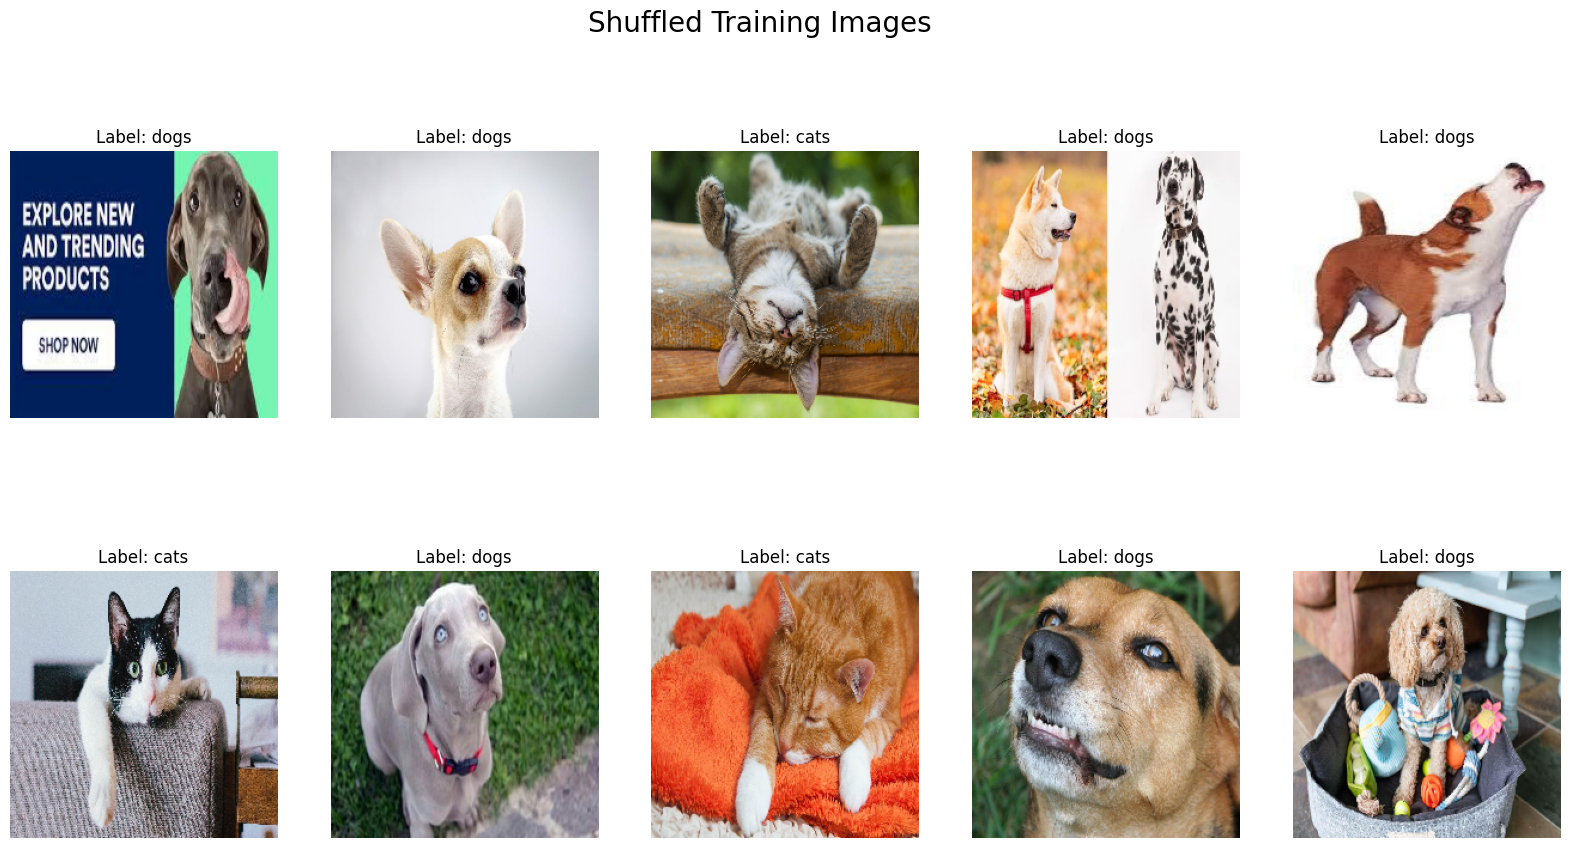

In [8]:
# Visualize some sample images from the shuffled training set
plot_sample_images(train_images, train_labels_encoded, title="Shuffled Training Images")

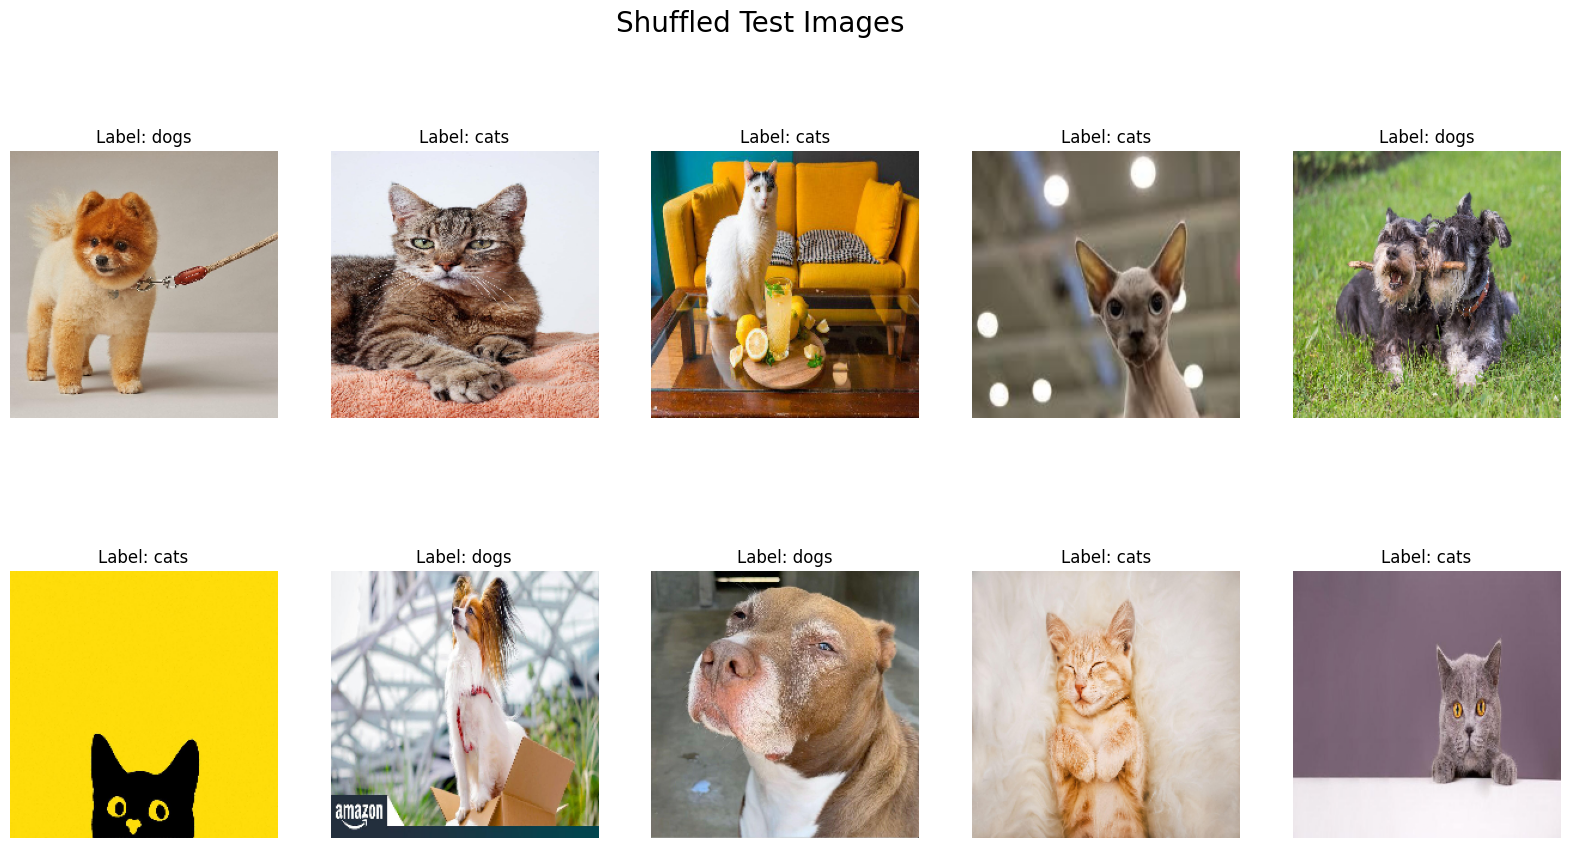

In [9]:
# Visualize some sample images from the shuffled test set
plot_sample_images(test_images, test_labels_encoded, title="Shuffled Test Images")


In [10]:
# Load the VGG16 model pre-trained on ImageNet, without the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a flattening layer to convert the 3D output to 1D
x = Flatten()(base_model.output)

# Create a model with the VGG16 base and the added flattening layer
model = Model(inputs=base_model.input, outputs=x)

# Extract features from the training and testing images
train_features = model.predict(train_images)
test_features = model.predict(test_images)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step


In [18]:
# Train the SVM classifier
svm_model = SVC(kernel='linear',C=10)
svm_model.fit(train_features, train_labels)

SVC(C=10, kernel='linear')

Classification Report:

              precision    recall  f1-score   support

        cats       0.78      0.76      0.77        70
        dogs       0.76      0.79      0.77        70

    accuracy                           0.77       140
   macro avg       0.77      0.77      0.77       140
weighted avg       0.77      0.77      0.77       140



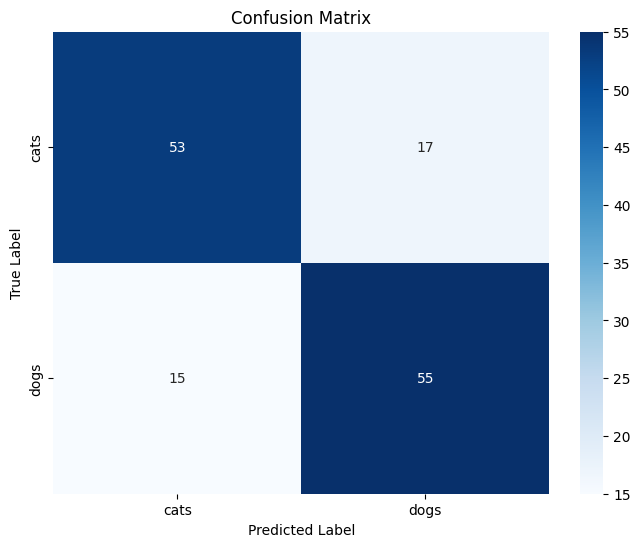

In [19]:
# Predict the labels for the test data
test_predictions = svm_model.predict(test_features)

# Classification report
print("Classification Report:\n")
print(classification_report(test_labels, test_predictions, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
# Ensure predictions are in the same format as the encoded labels
encoded_predictions = label_encoder.transform(test_predictions)

In [24]:
def plot_sample_images_and_predictions(images, labels, predictions=None, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(images[i])
        if predictions is not None:
            plt.title(f"True: {label_encoder.inverse_transform([labels[i]])[0]}\nPred: {label_encoder.inverse_transform([predictions[i]])[0]}")
        else:
            plt.title(f"Label: {label_encoder.inverse_transform([labels[i]])[0]}")
        plt.axis('off')
    plt.show()

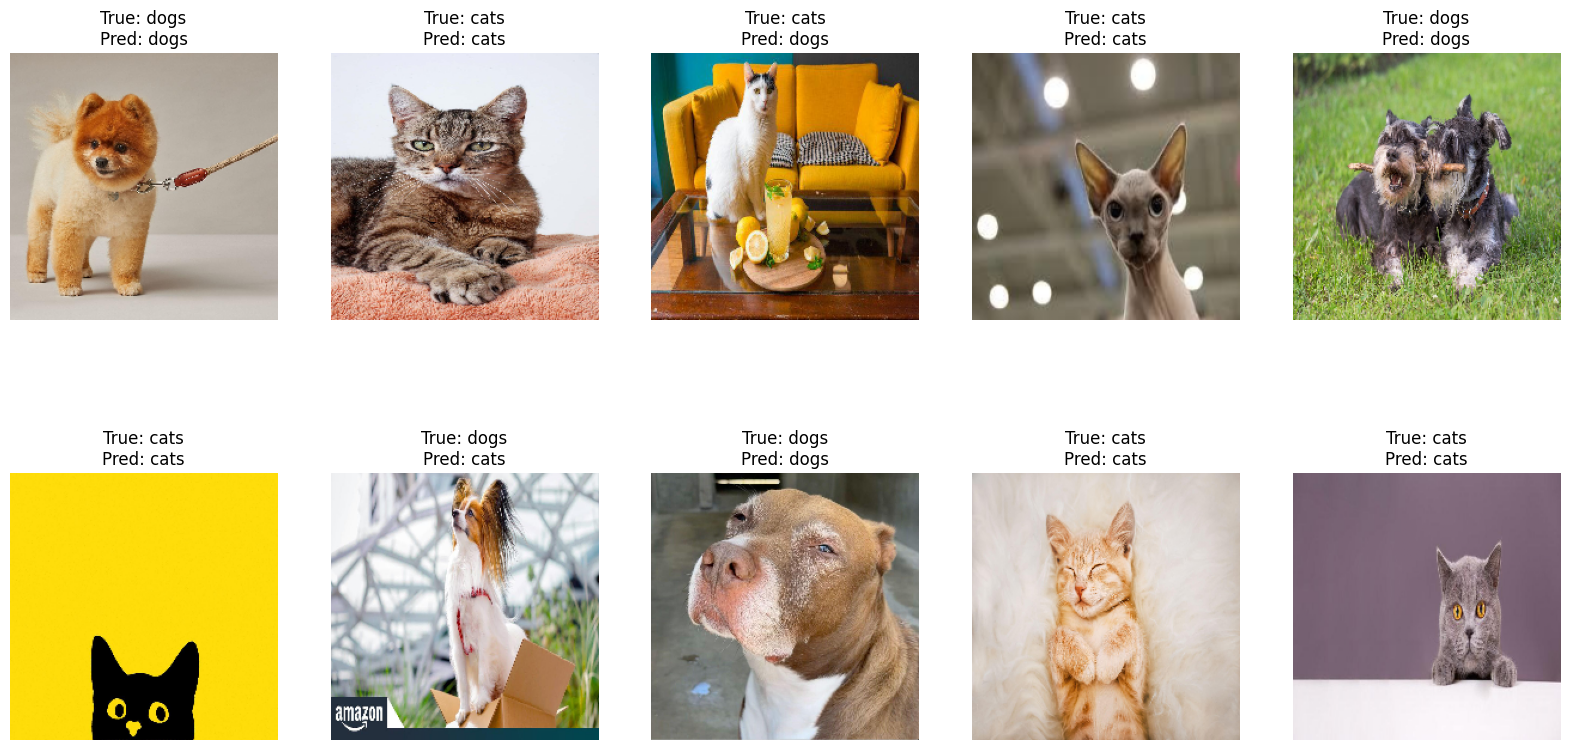

In [25]:
# Visualize some sample images from the test set with the encoded predictions
plot_sample_images_and_predictions(test_images , test_labels_encoded, encoded_predictions)